# Exploratory Data Analysis

## Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

In [2]:
# custom dtypes for data
from scripts.utils_data import DTYPES_SIMPLE, lemma
from scripts.utils_visualizations import show_distribution
from scripts.utils_data import range_without_outliers

In [3]:
# wordcloud
from wordcloud import WordCloud, STOPWORDS

In [4]:
# sklearn models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split

## Constants 

In [5]:
PATH_SIMPLE = '../data/processed/electronics_simple.csv'
PATH_SAMPLE = '../data/processed/electronics_simple_100K.csv'

## Load Data

In [6]:
df = pd.read_csv(PATH_SIMPLE,
                 low_memory=True,
                 dtype=DTYPES_SIMPLE)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6739590 entries, 0 to 6739589
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   overall      int16 
 1   vote         int64 
 2   reviewMonth  int16 
 3   reviewText   object
 4   reviewYear   int16 
dtypes: int16(3), int64(1), object(1)
memory usage: 141.4+ MB


In [8]:
df.head()

,overall,vote,reviewMonth,reviewText,reviewYear
0,5,67,9,This is the best novel I have read in 2 or 3 y...,1999
1,3,5,10,"Pages and pages of introspection, in the style...",2013
2,5,4,9,This is the kind of novel to read when you hav...,2008
3,5,13,9,What gorgeous language! What an incredible wri...,2000
4,3,8,2,I was taken in by reviews that compared this b...,2000


## Visualizations

In [9]:
# Calculate distribution
rating_cnt = df.overall.value_counts()
vote_cnt = df.vote.value_counts()
month_cnt = df.reviewMonth.value_counts()
year_cnt = df.reviewYear.value_counts()

df_vote_pos = pd.cut(df.vote.values,
                     bins=[0,1,float("inf")],
                     right=False,
                     labels=['No','Yes']).value_counts()

# calculating char length
df['textLength'] = df.reviewText.str.len()

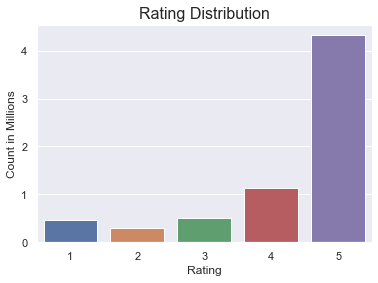

In [10]:
show_distribution(rating_cnt, 'Rating Distribution', 'Rating', normalize=1_000_000, norm_name='Millions')
plt.show()

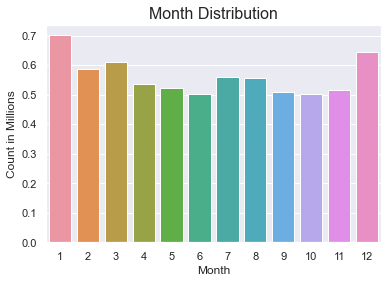

In [11]:
show_distribution(month_cnt, 'Month Distribution', 'Month', normalize=1_000_000, norm_name='Millions')
plt.show()

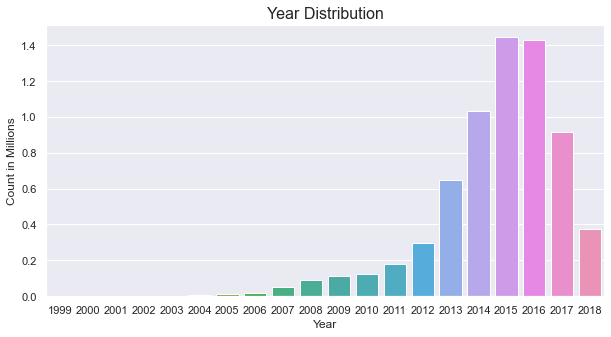

In [12]:
show_distribution(year_cnt, 'Year Distribution', 'Year',
                  normalize=1_000_000, norm_name='Millions',
                  figsize=(10,5))
plt.show()

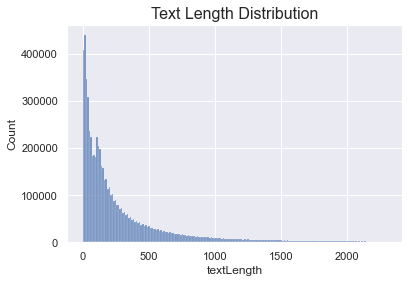

In [13]:
sns.histplot(x=df.textLength,
             bins=200,
             binrange=range_without_outliers(df.textLength, lower=0.))
plt.title("Text Length Distribution", fontsize=16)
plt.show()

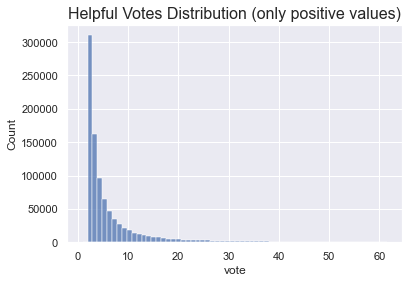

In [14]:
sns.histplot(x=df.vote,
             bins=62,
             binrange=range_without_outliers(df.vote, lower=1.))
plt.title("Helpful Votes Distribution (only positive values)", fontsize=16)
plt.show()

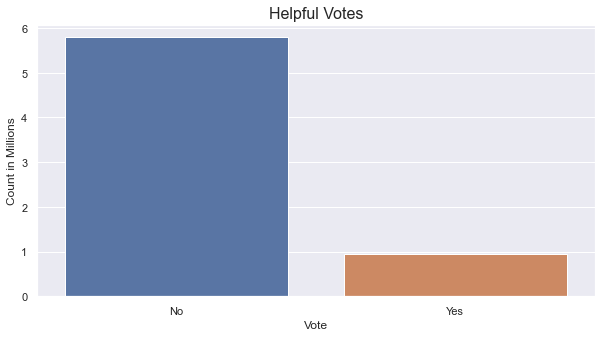

In [15]:
show_distribution(df_vote_pos, 'Helpful Votes', 'Vote',
                  normalize=1_000_000, norm_name='Millions',
                  figsize=(10,5))
plt.show()

## Text Exploration

Using 100K rows sample

In [16]:
df_new = pd.read_csv(PATH_SAMPLE, dtype=DTYPES_SIMPLE).dropna()

In [17]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99136 entries, 0 to 99148
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   overall      99136 non-null  int16 
 1   vote         99136 non-null  int64 
 2   reviewMonth  99136 non-null  int16 
 3   reviewText   99136 non-null  object
 4   reviewYear   99136 non-null  int16 
dtypes: int16(3), int64(1), object(1)
memory usage: 2.8+ MB


In [18]:
# Calculate Stats
df_new['word_cnt'] = df_new['reviewText'].str.split().str.len()

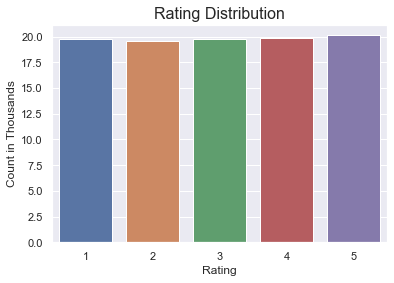

In [19]:
show_distribution(df_new.overall.value_counts(), 'Rating Distribution', 'Rating', normalize=1_000, norm_name='Thousands')
plt.show()

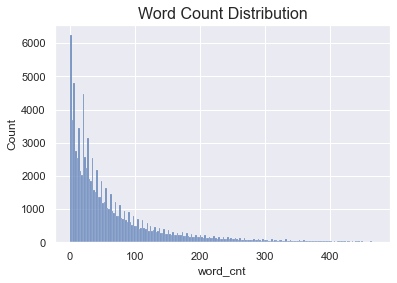

In [20]:
sns.histplot(x=df_new.word_cnt,
             bins=200,
             binrange=range_without_outliers(df_new.word_cnt, lower=1.))
plt.title("Word Count Distribution", fontsize=16)
plt.show()

In [21]:
## Word Cloud

wc_text = {}
for i in range(1,6):
    wc_text[i] = ' '.join(df_new[df_new.overall==i].reviewText.to_list())

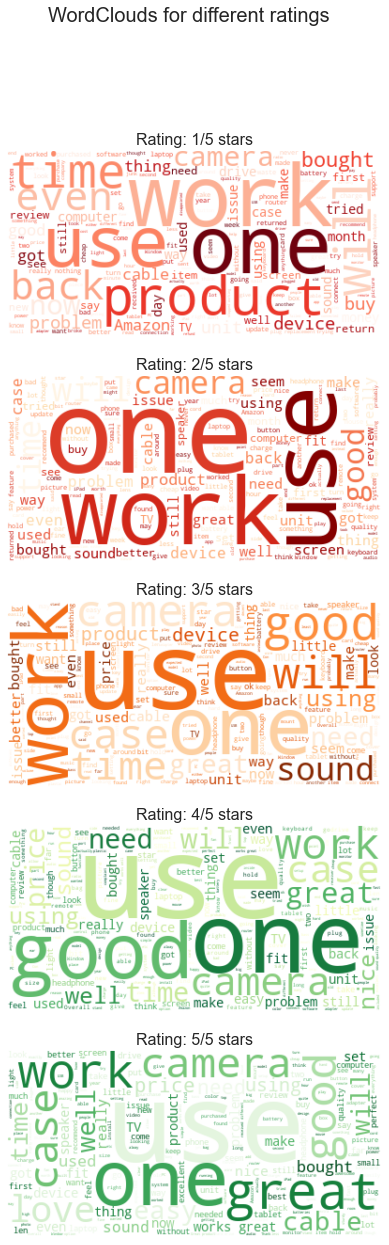

In [22]:
# Create stopword list:
stopwords = set(STOPWORDS)
cmaps = ['Reds','OrRd','Oranges','YlGn','Greens']

# Generate a word cloud image
wordclouds = {}
for i in range(1,6):
    wordclouds[i] = WordCloud(stopwords=stopwords,
                              max_words=1_000,
                              colormap=cmaps[i-1],
                              background_color="white").generate(wc_text[i])

# Display the generated image:
# the matplotlib way:
fig, ax = plt.subplots(5, figsize=(7,20))
fig.suptitle('WordClouds for different ratings', fontsize=20)
for i in range(1,6):
    ax[i-1].set_title(f'Rating: {i}/5 stars', fontsize=16)
    ax[i-1].imshow(wordclouds[i], interpolation='bilinear')
    ax[i-1].axis("off")
plt.show()

## Baseline Model - Sentiment Analysis

In [23]:
X = df_new['reviewText']
y = df_new['overall']-1

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [25]:
# updating stopwords
stopwords = set(STOPWORDS)
stopwords.update(['product','buy', 'purchase'])
stopwords = list(stopwords)

In [26]:
# creating tfidf model
tfidf = TfidfVectorizer(max_features=1_000, max_df=0.9999,ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [27]:
rf = RandomForestClassifier(n_estimators=200, max_depth=20)
rf.fit(X_train_tfidf, y_train)
rf.score(X_test_tfidf, y_test)

0.42197901956828726

In [28]:
y_test_pred = rf.predict(X_test_tfidf)

In [29]:
cl_report = pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True)).T
display(cl_report)

,precision,recall,f1-score,support
0,0.491064,0.639353,0.555482,3954.000000
1,0.343226,0.203416,0.255442,3923.000000
2,0.370769,0.235875,0.288325,3947.000000
3,0.388355,0.375755,0.381951,3976.000000
4,0.436218,0.649454,0.521895,4028.000000
accuracy,0.421979,0.421979,0.421979,0.421979
macro avg,0.405926,0.420770,0.400619,19828.000000
weighted avg,0.406130,0.421979,0.401317,19828.000000


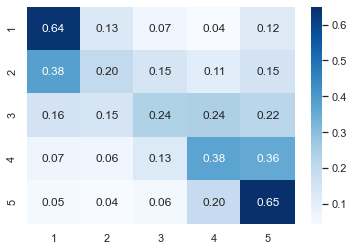

In [30]:
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm, cmap='Blues',
                yticklabels=range(1,6),
                xticklabels=range(1,6),
                annot=True, 
                fmt='.2f'
                )
plt.show()

In [32]:
gb = GradientBoostingClassifier(n_estimators=20, max_depth=10, max_features=0.6, subsample=0.6)
gb.fit(X_train_tfidf, y_train)
gb.score(X_test_tfidf, y_test)

0.412194875933024

In [33]:
y_test_pred_gb = gb.predict(X_test_tfidf)

In [34]:
cl_report_gb = pd.DataFrame(classification_report(y_test, y_test_pred_gb, output_dict=True)).T
display(cl_report_gb)

,precision,recall,f1-score,support
0,0.523884,0.507587,0.515607,3954.000000
1,0.288566,0.379556,0.327865,3923.000000
2,0.369139,0.267292,0.310066,3947.000000
3,0.377341,0.410463,0.393206,3976.000000
4,0.544609,0.494042,0.518094,4028.000000
accuracy,0.412195,0.412195,0.412195,0.412195
macro avg,0.420708,0.411788,0.412968,19828.000000
weighted avg,0.421347,0.412195,0.413507,19828.000000


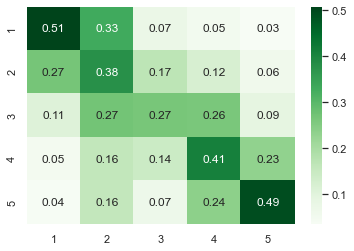

In [35]:
cm_gb = confusion_matrix(y_test, y_test_pred_gb, normalize='true')
sns.heatmap(cm_gb, cmap='Greens',
                yticklabels=range(1,6),
                xticklabels=range(1,6),
                annot=True, 
                fmt='.2f'
                )
plt.show()

In [36]:
feat_imp = pd.DataFrame({'feature':tfidf.get_feature_names(),'value':rf.feature_importances_})

In [37]:
feat_imp_most = feat_imp.sort_values(by='value', ascending=False)[:25]

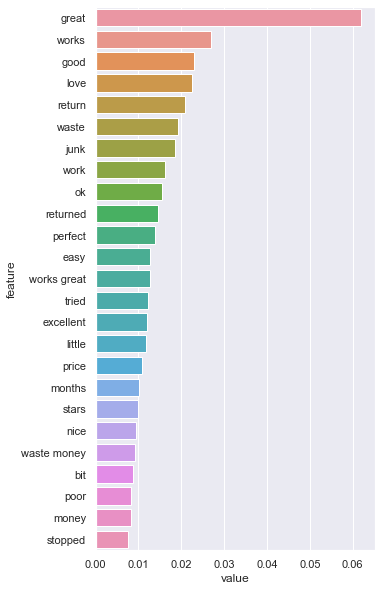

In [38]:
fig, ax = plt.subplots(figsize=(5,10))
sns.barplot(y='feature', x='value', data=feat_imp_most, ax =ax)
plt.show()